# Helmet detection

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

100% 1.22G/1.22G [00:13<00:00, 94.3MB/s]
100% 1.22G/1.22G [00:13<00:00, 99.0MB/s]


In [ ]:
!unzip hard-hat-detection.zip; rm hard-hat-detection.zip

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
import os

# Prepare Data for YOLOv5 Format

**Create directories to hold images and txt files for annotations (train , val ,test)**

In [5]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [6]:
classes = ['helmet','head','person']

In [7]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]


In [8]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/content/Dataset/labels/' +  img_jpg_file_name + '.txt'
    print(save_file_name)
    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [9]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data

    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)

        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])


    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
files = os.listdir('/content/annotations')
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    print(file_xml[0])
    get_xml_data('/content/annotations', file_xml[0])

# split train val test

In [11]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/content/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [12]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( '/content/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    root_file = Path('/content/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in file_list:
        img_name = file.replace('.png', '')
        img_src_file = imgs_source + '/' + img_name + '.png'
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        #print(img_sor_file)
        #print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = '/content/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = '/content/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [13]:
copy_data(train_list, '/content/Dataset/labels', '/content/images', "train")
copy_data(val_list,   '/content/Dataset/labels', '/content/images', "val")
copy_data(test_list,  '/content/Dataset/labels', '/content/images', "test")

Path /content/Dataset/images/train does not exit
Path /content/Dataset/labels/train does not exit
Path /content/Dataset/images/val does not exit
Path /content/Dataset/labels/val does not exit
Path /content/Dataset/images/test does not exit
Path /content/Dataset/labels/test does not exit


In [15]:
!ls /content/Dataset/images

test  train  val


# Get YOLOv5 model

In [16]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16057, done.
remote: Total 16057 (delta 0), reused 0 (delta 0), pack-reused 16057
Receiving objects: 100% (16057/16057), 14.66 MiB | 29.10 MiB/s, done.
Resolving deltas: 100% (11028/11028), done.
/content/yolov5


In [17]:
!ls

benchmarks.py	 data	     LICENSE	      requirements.txt	tutorial.ipynb
CITATION.cff	 detect.py   models	      segment		utils
classify	 export.py   README.md	      setup.cfg		val.py
CONTRIBUTING.md  hubconf.py  README.zh-CN.md  train.py


**create yaml file for configuration**

In [20]:
import yaml

dict_file = {'train':'/content/Dataset/images/train' ,
            'val': '/content/Dataset/images/val',
            'nc' : '3',
            'names' : ['helmet','head','person']}

with open('/content/yolov5/data/hard_head.yaml', 'w+') as file:
    documents = yaml.dump(dict_file, file)

In [21]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [22]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [24]:
num_classes=3

In [25]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [26]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data 'data/hard_head.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 7.2 MB/s eta 0:00:00
2023-11-10 11:12:11.852056: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 11:12:11.852123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 11:12:11.852169: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
requirements: Ultralytics requirement ['gitpython'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00

requirements:

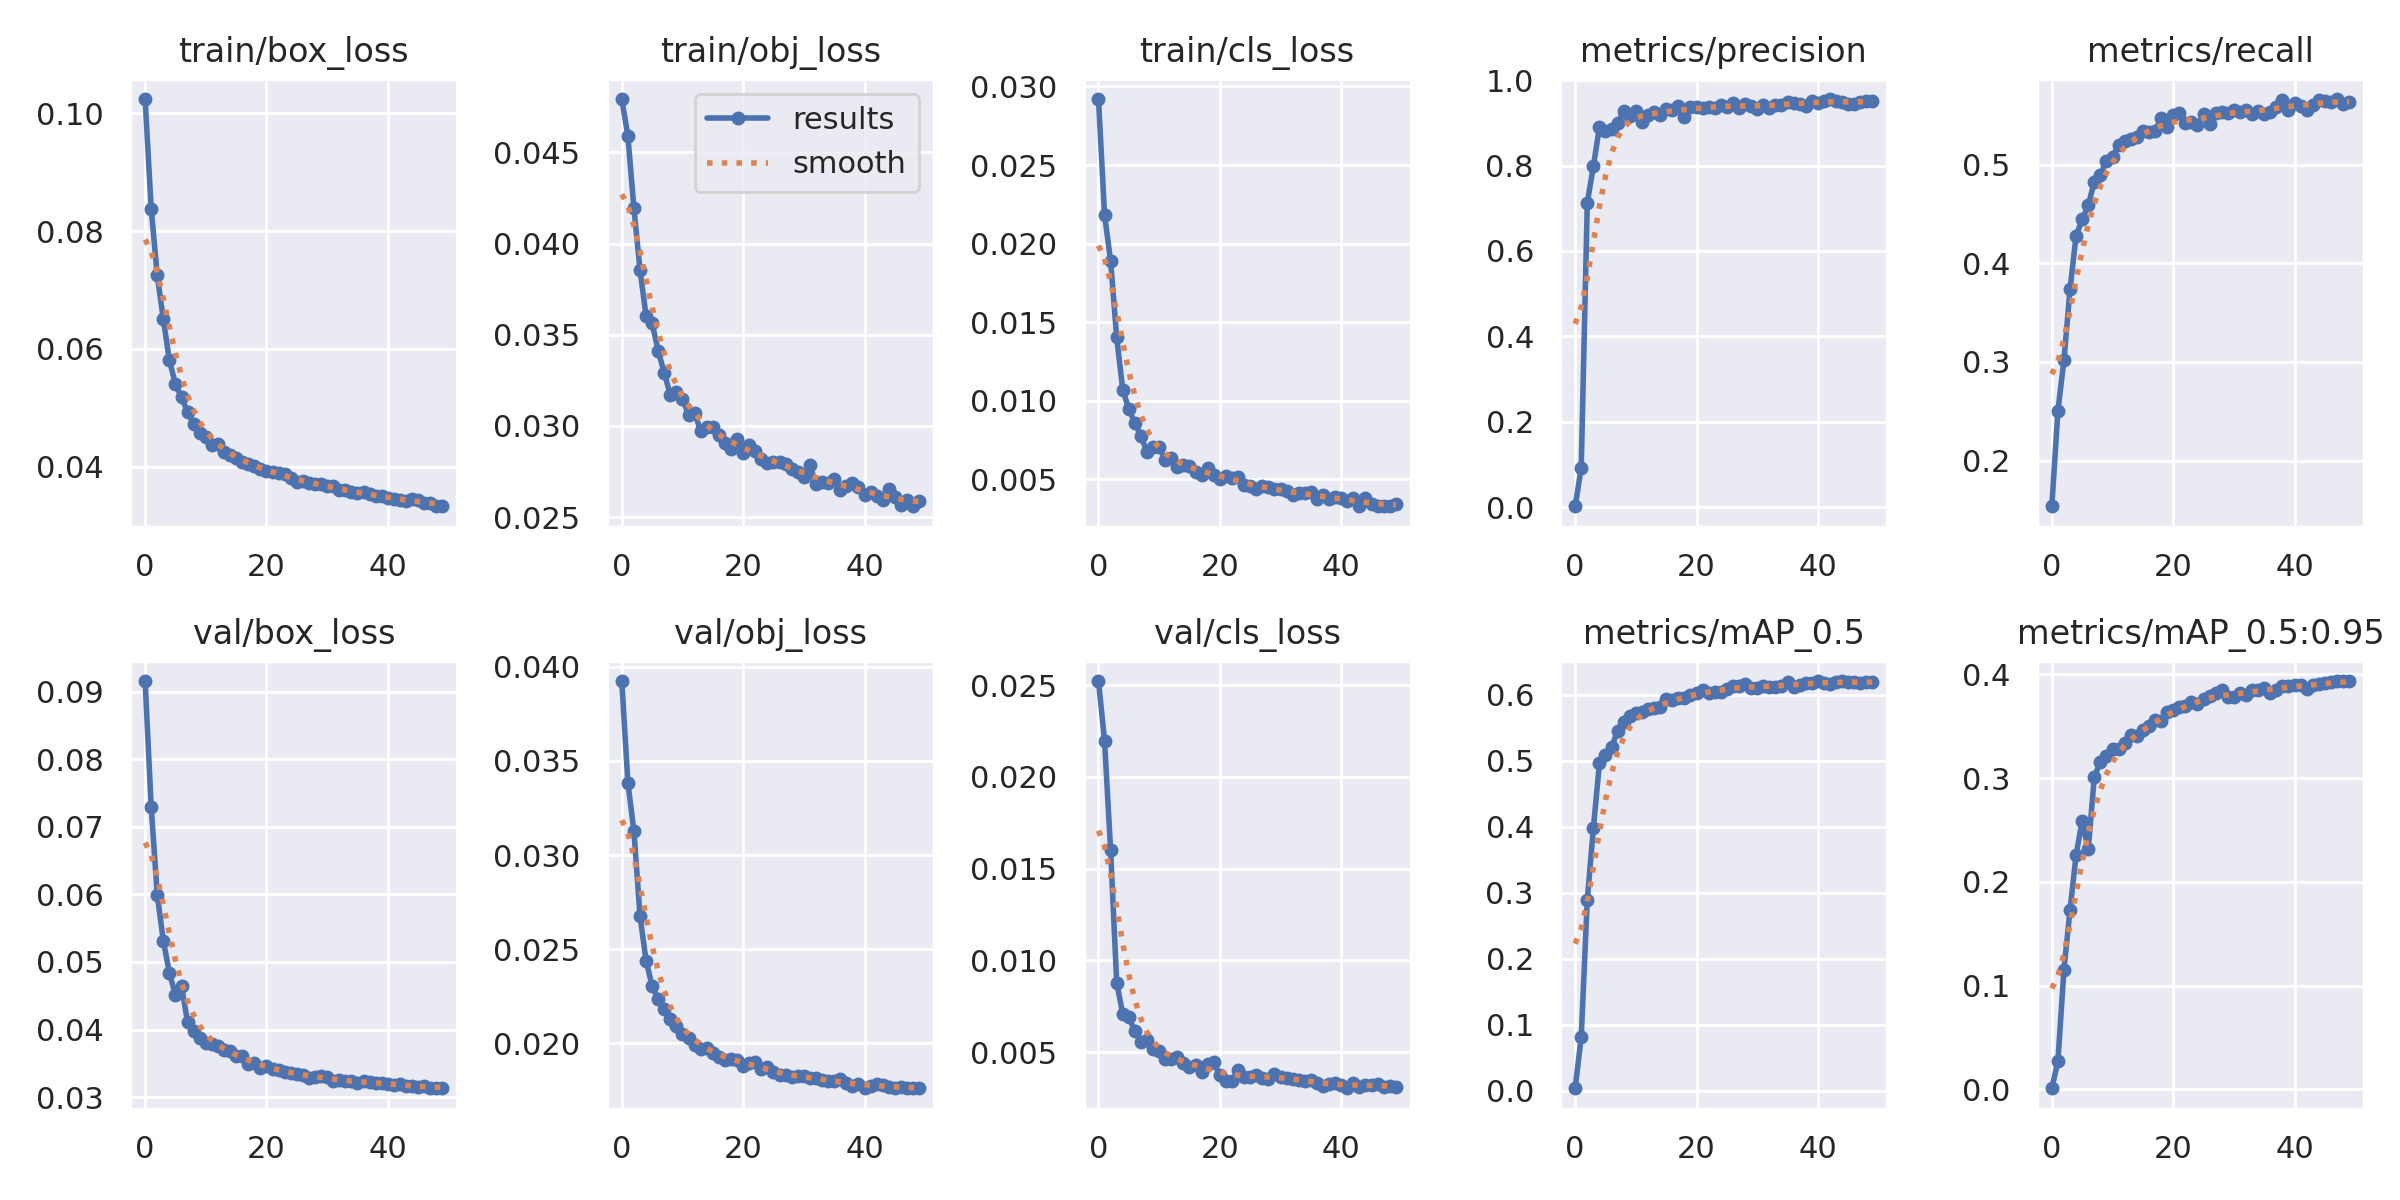

In [28]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
from IPython.display import Image
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


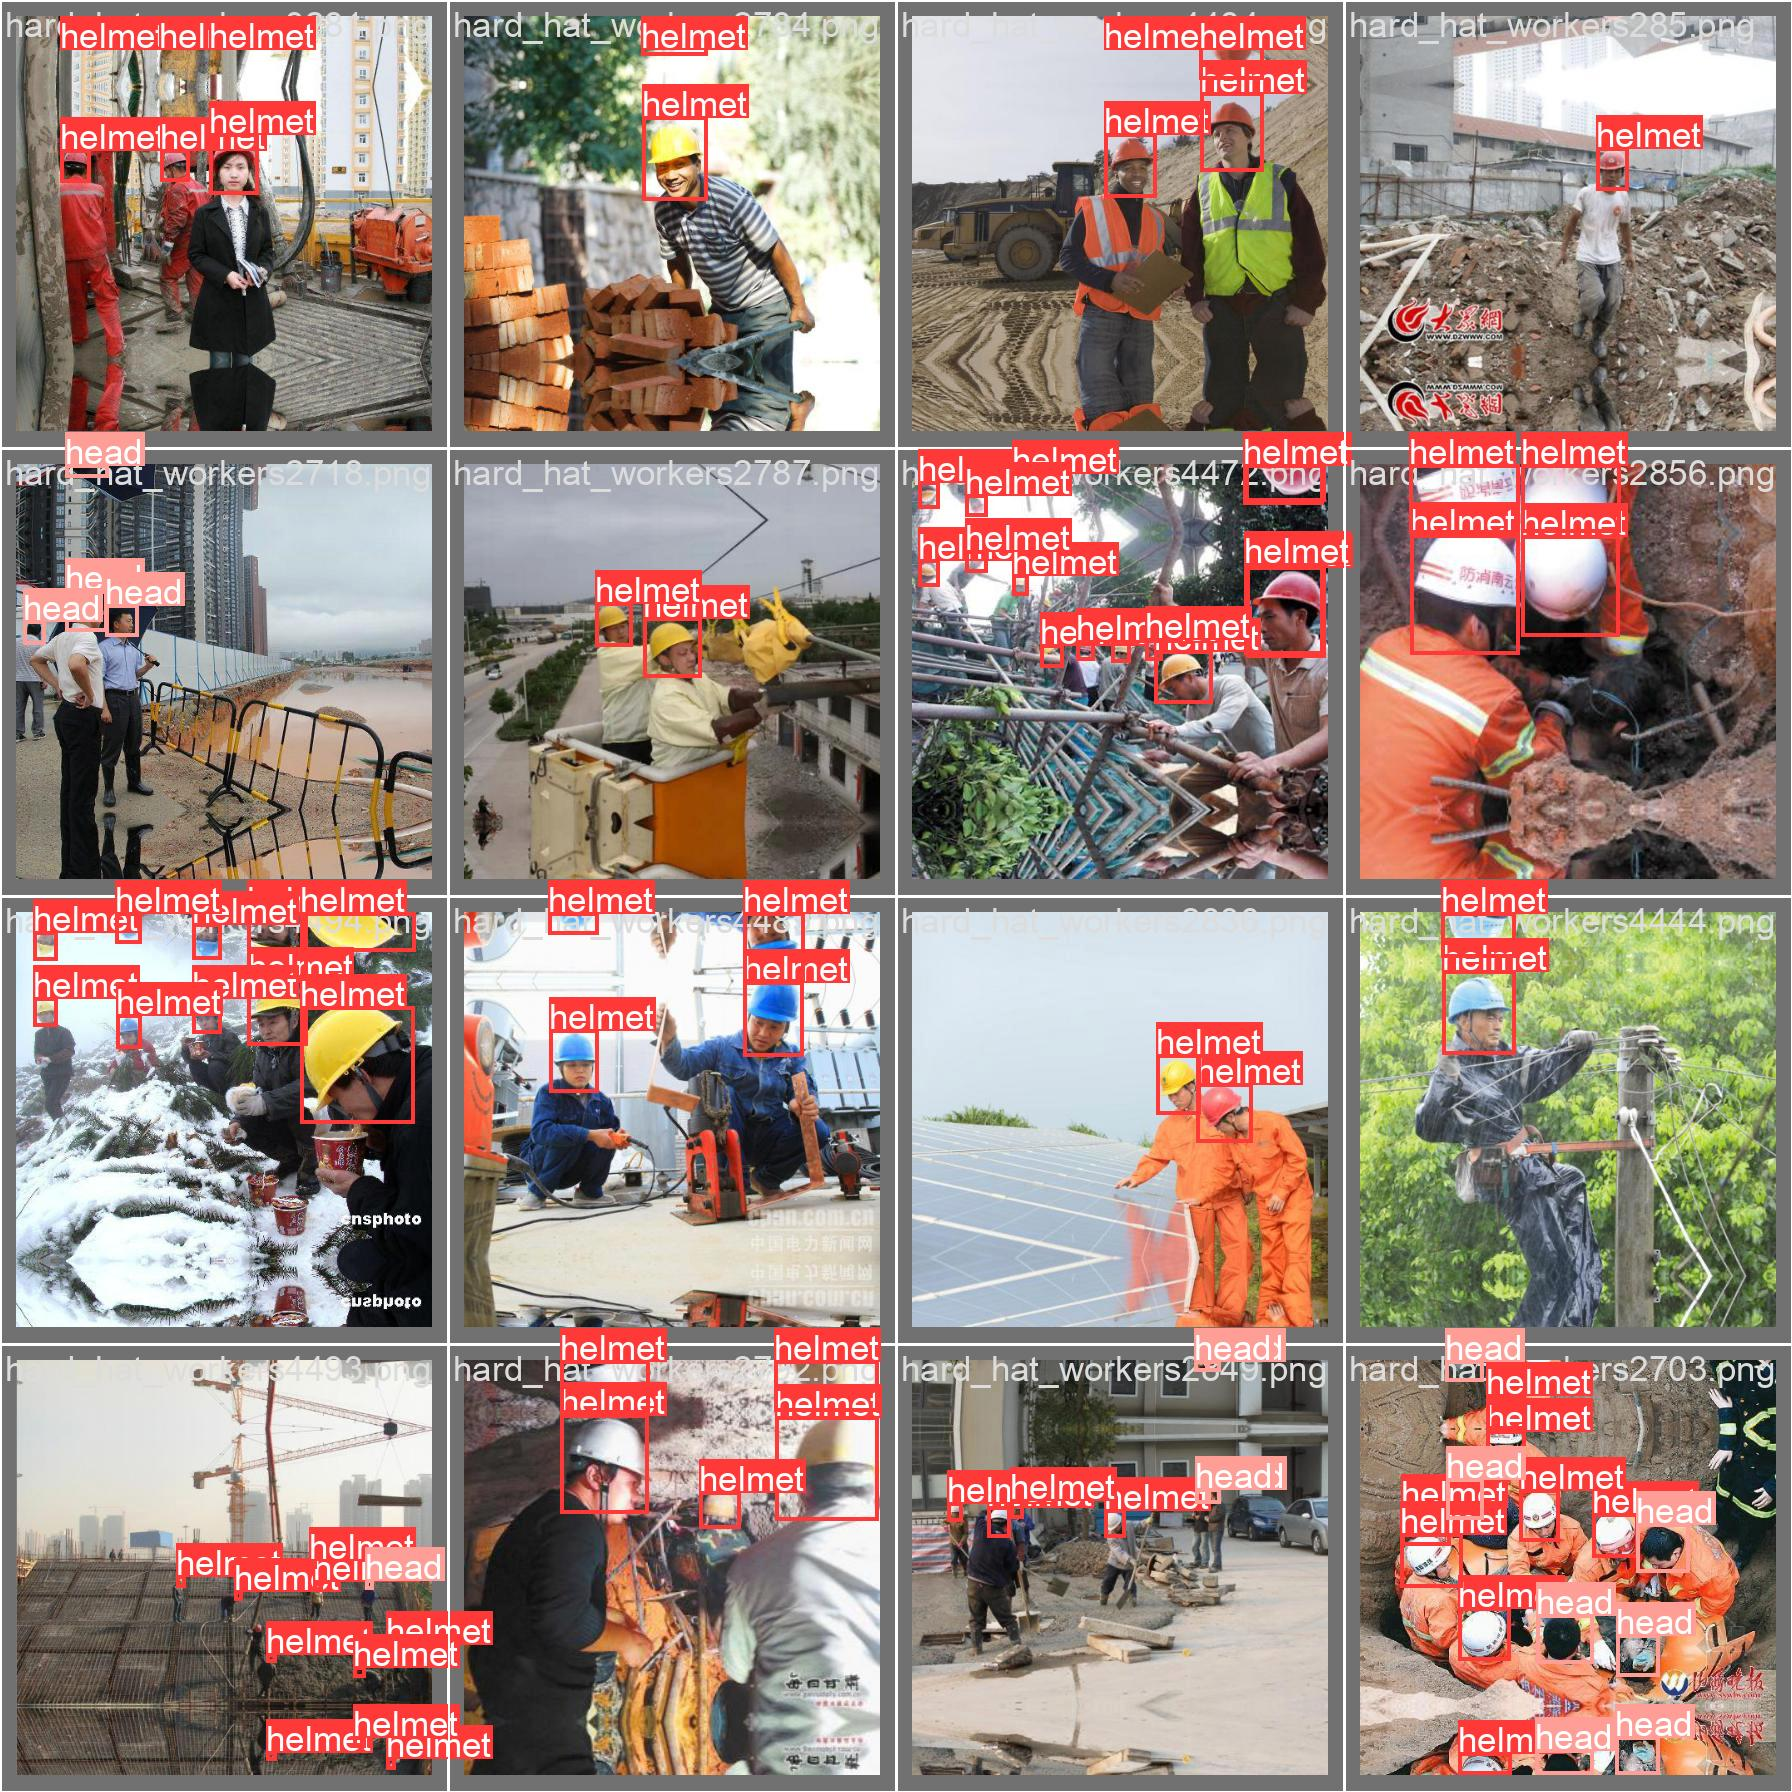

In [29]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


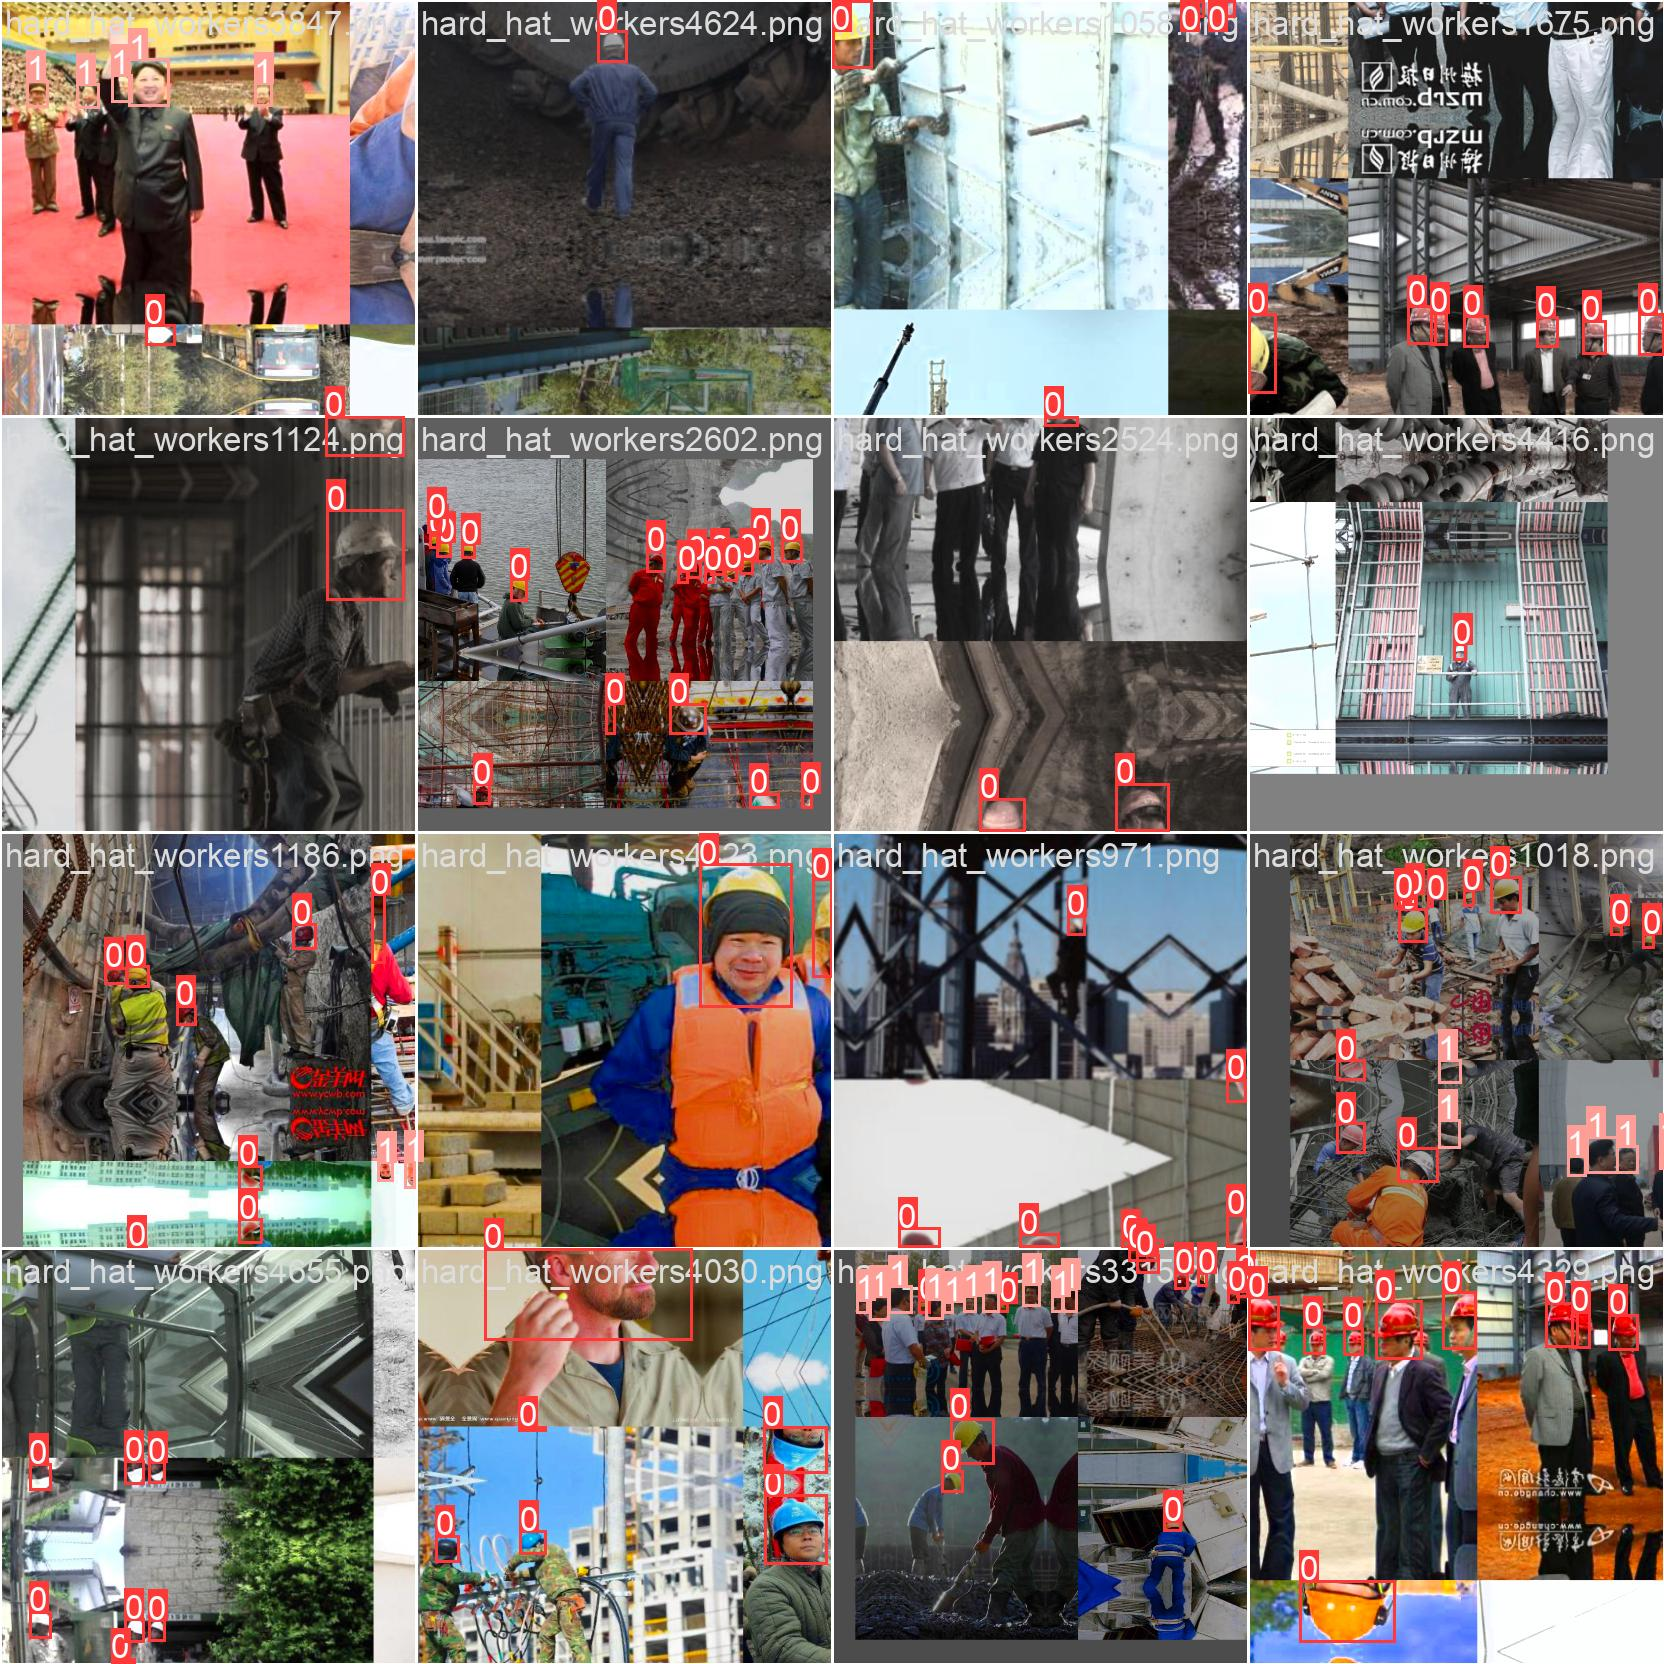

In [30]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [31]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [32]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [33]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source /content/Dataset/images/test

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/Dataset/images/test, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/500 /content/Dataset/images/test/hard_hat_workers0.png: 416x416 5 helmets, 6 heads, 8.0ms
image 2/500 /content/Dataset/images/test/hard_hat_workers100.png: 416x416 5 helmets, 8.0ms
image 3/500 /content/Dataset/images/test/hard_hat_workers1001.png: 416x416 4 helmets, 8.0ms
image 4/500 /cont